# Difference in the hidden_states

In [30]:
import torch
from transformers import PreTrainedTokenizerFast
import numpy as np

In [36]:
import omegaconf
path = r"CONFIG-PATH"
conf = omegaconf.OmegaConf.load(path)

In [2]:
import sys

sys.path.insert(0, r"PROJECT-PATH") 

from transformer_implementation import transformer
from util.prepare_model import prepare_test


In [5]:
np.random.seed(46)
torch.manual_seed(46)

model, tokenizer = prepare_test(conf)

text = "However, we in Parliament also have a supervisory role with regard to the Commission and we do not have to agree with everything which comes out of the Commission."
target = "Aber wir als Parlament sind auch der Kontrolleur der Kommission. Und nicht alles, was von der Kommission kommt, muß unsere Meinung sein."
inputs = tokenizer(text, add_special_tokens=True, return_tensors="pt")
print(inputs)
target_tokens = tokenizer(target, add_special_tokens=True, return_tensors="pt")
print(target_tokens["input_ids"][0][0])


{'input_ids': tensor([[    1,   566,   189,   213,    13,   189,   103,  2239,   235,  5664,
          5352,  2206,    60,  4912,  8874,    84, 18742,   155,  5068,   347,
           151,   137,  1855, 34659,   121,   189,   180,  3385,  2206,   151,
           624,   355,   155,  8573,   565,  2297,  7098,   276,   148,   137,
          1855, 34659,    15,     2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor(1)


In [6]:
with torch.no_grad():
    logits, loss, last_hidden_states, attentions_array = model(inputs["input_ids"], target_tokens["input_ids"], inputs["attention_mask"], target_tokens["attention_mask"], last_hidden_states=True, output_attentions=True)


In [13]:
last_hidden_states.shape

torch.Size([1, 36, 512])

In [29]:
diffs = []
for i in range(last_hidden_states.shape[1]):
    gap = 0
    for j in range(last_hidden_states.shape[1]):
        if j != i:
            gap += torch.sum(torch.abs(last_hidden_states[0][i] - last_hidden_states[0][j]))/last_hidden_states.shape[-1]
    diffs.append(gap)
print(f"Difference between each hidden state: {diffs} with len {len(diffs)}")


Difference between each hidden state: [tensor(42.9731), tensor(42.0072), tensor(38.7744), tensor(42.0370), tensor(40.9112), tensor(39.9935), tensor(40.0195), tensor(40.2425), tensor(41.3352), tensor(42.5116), tensor(40.5111), tensor(39.4051), tensor(41.5198), tensor(39.7657), tensor(38.6789), tensor(43.9643), tensor(37.4631), tensor(35.6786), tensor(35.7449), tensor(36.6782), tensor(36.4163), tensor(36.2322), tensor(40.0779), tensor(37.1656), tensor(35.5759), tensor(36.0694), tensor(36.6024), tensor(36.6298), tensor(36.6564), tensor(36.7059), tensor(36.0944), tensor(36.4106), tensor(37.2401), tensor(36.5672), tensor(44.9836), tensor(46.1196)] with len 36


In [8]:
last_hidden_states[0][0][0:25], last_hidden_states[0][-1][0:25]

(tensor([-0.4472, -1.5383, -1.0179,  1.0165,  0.1279, -0.8664, -2.0355, -1.1538,
          0.1597, -2.1707, -2.6841,  1.5353,  0.1131,  1.4323, -1.2051,  0.7774,
          0.6282,  2.1580, -1.1236, -0.2668, -0.5167, -0.7873, -1.2380, -0.1678,
          0.8293]),
 tensor([ 0.0980,  1.0914, -0.0707,  0.2338, -1.7034, -0.2862,  0.4016,  0.4812,
          0.0736, -1.6723,  0.5512, -0.3839,  0.3622, -0.1609, -0.7015,  0.4178,
         -0.6491, -0.0874,  0.4646, -0.0973, -0.0436,  0.1668, -3.8233,  0.0441,
          0.1232]))

In [9]:
(last_hidden_states[0][0] - last_hidden_states[0][-1])[:20]

tensor([-0.5452, -2.6297, -0.9473,  0.7827,  1.8313, -0.5802, -2.4371, -1.6350,
         0.0862, -0.4984, -3.2354,  1.9192, -0.2490,  1.5932, -0.5036,  0.3596,
         1.2773,  2.2454, -1.5882, -0.1695])

In [30]:
torch.sum(torch.abs(last_hidden_states[0][0] - last_hidden_states[0][-1]))/last_hidden_states.shape[-1]

tensor(1.3676)

Now there is a clear diference between the hidden_states. So we can see that the model has learned to change the predictions based on the context.

## Attention mask

In [32]:
attentions_array[0].shape, len(attentions_array)

(torch.Size([1, 8, 36, 36]), 6)

In [33]:
diffs = []
for i in range(len(attentions_array)):
    gap = 0
    for j in range(len(attentions_array)):
        if j != i:
            gap += torch.sum(torch.abs(attentions_array[i][0][0] - attentions_array[j][0][0]))/attentions_array[0][0][0].shape[-1]
    diffs.append(gap)
print(f"Difference between each attention layer: {diffs} with len {len(diffs)}")


Difference between each attention layer: [tensor(6.3151), tensor(5.4291), tensor(5.6988), tensor(5.8325), tensor(5.1745), tensor(5.7326)] with len 6


In [34]:
attentions_array[0][0][0]

tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3018, 0.6982, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0829, 0.3011, 0.6160,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0048, 0.0443, 0.0390,  ..., 0.0071, 0.0000, 0.0000],
        [0.0034, 0.0190, 0.0357,  ..., 0.0065, 0.0017, 0.0000],
        [0.0059, 0.0213, 0.0347,  ..., 0.0072, 0.0014, 0.0241]])

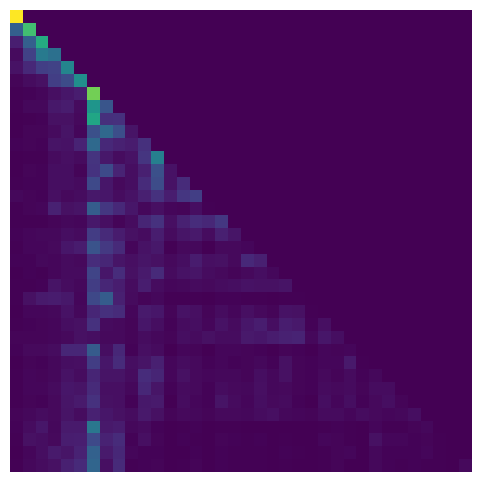

In [45]:
import matplotlib.pyplot as plt
import numpy as np

attentions_numpy = attentions_array[0][0][0].numpy()
plt.figure(figsize=(6, 6))
plt.imshow(attentions_numpy)
plt.axis('off')
plt.show()


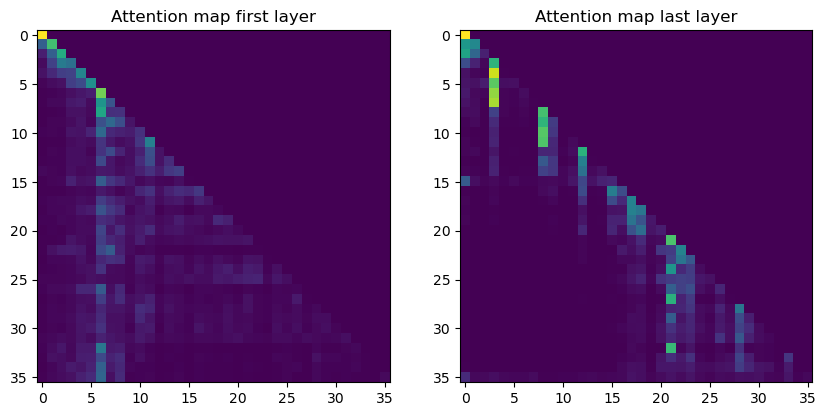

In [43]:
import matplotlib.pyplot as plt
import numpy as np

attentions_numpy_0 = attentions_array[0][0][0].numpy()
attentions_numpy_5 = attentions_array[-1][0][0].numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(attentions_numpy_0)
axs[0].set_title("Attention map first layer")
axs[1].imshow(attentions_numpy_5)
axs[1].set_title("Attention map last layer")

plt.show()

## Failed model
This model was trained for 2000 steps with a batch size of 192, but the warmup steps where to low so the model broke, smallest loss on validation was 4.5

In [37]:
import numpy as np
np.random.seed(46)
torch.manual_seed(46)

model, tokenizer = prepare_test(conf)

text = "However, we in Parliament also have a supervisory role with regard to the Commission and we do not have to agree with everything which comes out of the Commission."
target = "Aber wir als Parlament sind auch der Kontrolleur der Kommission. Und nicht alles, was von der Kommission kommt, muß unsere Meinung sein."
inputs = tokenizer(text, add_special_tokens=True, return_tensors="pt")
print(inputs)
target_tokens = tokenizer(target, add_special_tokens=True, return_tensors="pt")
print(target_tokens["input_ids"][0][0])
with torch.no_grad():
    logits, loss, last_hidden_states, attentions_array = model(inputs["input_ids"], target_tokens["input_ids"], inputs["attention_mask"], target_tokens["attention_mask"], last_hidden_states=True, output_attentions=True)


{'input_ids': tensor([[    1,   566,   189,   213,    13,   189,   103,  2239,   235,  5664,
          5352,  2206,    60,  4912,  8874,    84, 18742,   155,  5068,   347,
           151,   137,  1855, 34659,   121,   189,   180,  3385,  2206,   151,
           624,   355,   155,  8573,   565,  2297,  7098,   276,   148,   137,
          1855, 34659,    15,     2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor(1)


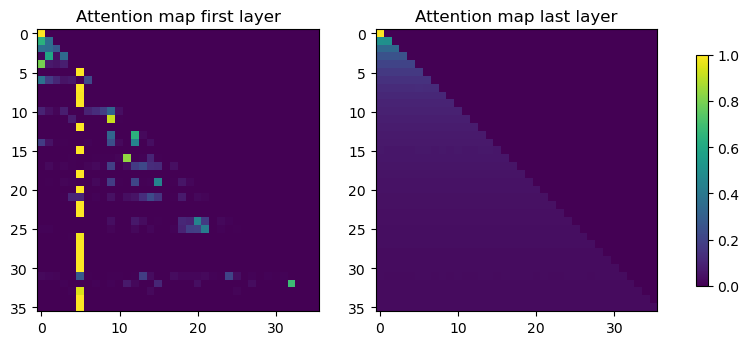

In [48]:
import matplotlib.pyplot as plt
import numpy as np

attentions_numpy_0 = attentions_array[0][0][0].numpy()
attentions_numpy_5 = attentions_array[-1][0][0].numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(attentions_numpy_0)
axs[0].set_title("Attention map first layer")
axs[1].imshow(attentions_numpy_5)
axs[1].set_title("Attention map last layer")
fig.colorbar(plt.cm.ScalarMappable(), ax=axs, shrink=0.3)
plt.show()

# Plot overfitting one batch

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

df = pd.read_csv(r"LOGS-PATH")
df

,Unnamed: 0,losses,gradient_norm,learning_rate
0,0,"[8.947648048400879, 8.939841270446777, 8.93004...","[8.179412841796875, 8.171945571899414, 8.11767...","[1.746928107421711e-07, 3.493856214843422e-07,..."


In [6]:
df["losses"][0]

'[8.947648048400879, 8.939841270446777, 8.930047035217285, 8.932550430297852, 8.944811820983887, 8.910247802734375, 8.892906188964844, 8.894241333007812, 8.858434677124023, 8.837726593017578, 8.825141906738281, 8.778119087219238, 8.747640609741211, 8.737935066223145, 8.679953575134277, 8.677717208862305, 8.621599197387695, 8.568243026733398, 8.536102294921875, 8.490978240966797, 8.422301292419434, 8.425297737121582, 8.350590705871582, 8.317708969116211, 8.270283699035645, 8.207164764404297, 8.151046752929688, 8.118732452392578, 8.056819915771484, 7.995318412780762, 7.967464923858643, 7.892711162567139, 7.842825412750244, 7.797593116760254, 7.746303081512451, 7.698915004730225, 7.631118297576904, 7.584076404571533, 7.54810905456543, 7.502900123596191, 7.449223041534424, 7.384243965148926, 7.370930194854736, 7.2977614402771, 7.263304710388184, 7.2254767417907715, 7.1861891746521, 7.146808624267578, 7.091609477996826, 7.059393405914307, 7.035025596618652, 6.9909162521362305, 6.96541357040

In [8]:
a = [8.947648048400879, 8.939841270446777, 8.930047035217285, 8.932550430297852, 8.944811820983887, 8.910247802734375, 8.892906188964844, 8.894241333007812, 8.858434677124023, 8.837726593017578, 8.825141906738281, 8.778119087219238, 8.747640609741211, 8.737935066223145, 8.679953575134277, 8.677717208862305, 8.621599197387695, 8.568243026733398, 8.536102294921875, 8.490978240966797, 8.422301292419434, 8.425297737121582, 8.350590705871582, 8.317708969116211, 8.270283699035645, 8.207164764404297, 8.151046752929688, 8.118732452392578, 8.056819915771484, 7.995318412780762, 7.967464923858643, 7.892711162567139, 7.842825412750244, 7.797593116760254, 7.746303081512451, 7.698915004730225, 7.631118297576904, 7.584076404571533, 7.54810905456543, 7.502900123596191, 7.449223041534424, 7.384243965148926, 7.370930194854736, 7.2977614402771, 7.263304710388184, 7.2254767417907715, 7.1861891746521, 7.146808624267578, 7.091609477996826, 7.059393405914307, 7.035025596618652, 6.9909162521362305, 6.965413570404053, 6.920928955078125, 6.888500213623047, 6.870778560638428, 6.834364414215088, 6.813312530517578, 6.774635314941406, 6.744987964630127, 6.73233699798584, 6.702500820159912, 6.671298027038574, 6.6594061851501465, 6.618712902069092, 6.598611831665039, 6.560176849365234, 6.539971351623535, 6.525265693664551, 6.483904838562012, 6.460841655731201, 6.44578218460083, 6.413576126098633, 6.385749816894531, 6.351591110229492, 6.3398966789245605, 6.309207916259766, 6.282104015350342, 6.253736972808838, 6.2182793617248535, 6.206412315368652, 6.173601150512695, 6.124708652496338, 6.114187717437744, 6.07969856262207, 6.046532154083252, 6.013369083404541, 5.982702732086182, 5.956318378448486, 5.914254665374756, 5.901645660400391, 5.86911678314209, 5.841568470001221, 5.809687614440918, 5.769831657409668, 5.721555709838867, 5.686094284057617, 5.670704364776611, 5.615703105926514, 5.601919174194336, 5.566347599029541, 5.519471168518066, 5.492214202880859, 5.46956729888916, 5.446082592010498, 5.407235145568848, 5.364499092102051, 5.321590423583984, 5.291877746582031, 5.273165225982666, 5.231817722320557, 5.207132339477539, 5.156649589538574, 5.12956428527832, 5.099983215332031, 5.0621137619018555, 5.032360553741455, 4.995258808135986, 4.977719783782959, 4.9351701736450195, 4.909941673278809, 4.868961811065674, 4.830657005310059, 4.80694055557251, 4.751961708068848, 4.72987174987793, 4.688122272491455, 4.666505813598633, 4.623620986938477, 4.602445125579834, 4.547060966491699, 4.517951488494873, 4.47869348526001, 4.450558185577393, 4.415896415710449, 4.37793493270874, 4.336710453033447, 4.306382179260254, 4.263090133666992, 4.2273454666137695, 4.195358753204346, 4.1577959060668945, 4.135557174682617, 4.0746331214904785, 4.052413463592529, 4.016306400299072, 3.973641872406006, 3.9478163719177246, 3.911620616912842, 3.8608593940734863]
len(a)

150

In [10]:
grads = [8.179412841796875, 8.171945571899414, 8.117674827575684, 8.133055686950684, 8.14954948425293, 8.093913078308105, 8.070540428161621, 8.03487491607666, 7.9598541259765625, 7.993358612060547, 7.89428186416626, 7.865476131439209, 7.798063278198242, 7.754297733306885, 7.6417107582092285, 7.610790729522705, 7.466305732727051, 7.340883255004883, 7.245603084564209, 7.127544403076172, 7.02103853225708, 6.886756420135498, 6.767005920410156, 6.6263933181762695, 6.399762153625488, 6.27032470703125, 6.1259613037109375, 5.9475417137146, 5.792624473571777, 5.588698387145996, 5.480654716491699, 5.301470756530762, 5.1548309326171875, 5.017370223999023, 4.861995697021484, 4.800350666046143, 4.631097793579102, 4.510421276092529, 4.393490791320801, 4.2987165451049805, 4.174847602844238, 4.058496952056885, 3.985567808151245, 3.8987338542938232, 3.8320236206054688, 3.760723829269409, 3.684644937515259, 3.619147300720215, 3.559086799621582, 3.507633924484253, 3.4433419704437256, 3.401014566421509, 3.3876445293426514, 3.3390445709228516, 3.288005828857422, 3.279388427734375, 3.265519142150879, 3.242948293685913, 3.236459732055664, 3.217372179031372, 3.224945545196533, 3.233365058898926, 3.2121922969818115, 3.2220048904418945, 3.1974427700042725, 3.188706159591675, 3.162511110305786, 3.143993616104126, 3.125033378601074, 3.0708343982696533, 3.0545499324798584, 3.0241317749023438, 2.985485792160034, 2.959498167037964, 2.9144608974456787, 2.8919224739074707, 2.8646178245544434, 2.8359618186950684, 2.786710739135742, 2.757862091064453, 2.731565237045288, 2.691288948059082, 2.6866700649261475, 2.64334774017334, 2.6022846698760986, 2.585789918899536, 2.559342384338379, 2.52597975730896, 2.505282402038574, 2.482851505279541, 2.443359851837158, 2.430224895477295, 2.3974521160125732, 2.381146192550659, 2.3522756099700928, 2.3202743530273438, 2.299165964126587, 2.26623797416687, 2.2483913898468018, 2.220090627670288, 2.175999879837036, 2.149264097213745, 2.1231722831726074, 2.0982472896575928, 2.0736677646636963, 2.0380642414093018, 2.0217652320861816, 2.004763603210449, 1.9818474054336548, 1.95783531665802, 1.9439436197280884, 1.918723464012146, 1.8917514085769653, 1.884096622467041, 1.866644024848938, 1.8379459381103516, 1.8147226572036743, 1.8078513145446777, 1.797436237335205, 1.7806971073150635, 1.7741349935531616, 1.762718677520752, 1.746950626373291, 1.7499510049819946, 1.72489333152771, 1.7197233438491821, 1.7059162855148315, 1.70168936252594, 1.6971410512924194, 1.6915127038955688, 1.6762288808822632, 1.67263662815094, 1.6685723066329956, 1.6630889177322388, 1.653965711593628, 1.6541359424591064, 1.6450368165969849, 1.6366798877716064, 1.633931279182434, 1.6255215406417847, 1.62251615524292, 1.607606291770935, 1.6035443544387817, 1.5985074043273926, 1.5982122421264648, 1.5878612995147705, 1.581303358078003, 1.5740598440170288, 1.5673595666885376, 1.5699492692947388]
len(grads)

150

In [12]:
learning_rate = [1.746928107421711e-07, 3.493856214843422e-07, 5.240784322265133e-07, 6.987712429686844e-07, 8.734640537108554e-07, 1.0481568644530267e-06, 1.2228496751951977e-06, 1.3975424859373688e-06, 1.57223529667954e-06, 1.7469281074217108e-06, 1.921620918163882e-06, 2.0963137289060533e-06, 2.271006539648224e-06, 2.4456993503903955e-06, 2.6203921611325664e-06, 2.7950849718747376e-06, 2.9697777826169085e-06, 3.14447059335908e-06, 3.3191634041012507e-06, 3.4938562148434215e-06, 3.668549025585593e-06, 3.843241836327764e-06, 4.017934647069935e-06, 4.192627457812107e-06, 4.367320268554277e-06, 4.542013079296448e-06, 4.71670589003862e-06, 4.891398700780791e-06, 5.066091511522962e-06, 5.240784322265133e-06, 5.415477133007304e-06, 5.590169943749475e-06, 5.7648627544916466e-06, 5.939555565233817e-06, 6.114248375975988e-06, 6.28894118671816e-06, 6.463633997460331e-06, 6.638326808202501e-06, 6.813019618944673e-06, 6.987712429686843e-06, 7.162405240429014e-06, 7.337098051171186e-06, 7.511790861913357e-06, 7.686483672655528e-06, 7.8611764833977e-06, 8.03586929413987e-06, 8.210562104882042e-06, 8.385254915624213e-06, 8.559947726366383e-06, 8.734640537108554e-06, 8.909333347850726e-06, 9.084026158592897e-06, 9.258718969335068e-06, 9.43341178007724e-06, 9.60810459081941e-06, 9.782797401561582e-06, 9.957490212303753e-06, 1.0132183023045925e-05, 1.0306875833788094e-05, 1.0481568644530265e-05, 1.0656261455272437e-05, 1.0830954266014608e-05, 1.100564707675678e-05, 1.118033988749895e-05, 1.1355032698241122e-05, 1.1529725508983293e-05, 1.1704418319725463e-05, 1.1879111130467634e-05, 1.2053803941209805e-05, 1.2228496751951977e-05, 1.2403189562694148e-05, 1.257788237343632e-05, 1.275257518417849e-05, 1.2927267994920662e-05, 1.3101960805662831e-05, 1.3276653616405003e-05, 1.3451346427147174e-05, 1.3626039237889345e-05, 1.3800732048631515e-05, 1.3975424859373686e-05, 1.4150117670115857e-05, 1.4324810480858029e-05, 1.44995032916002e-05, 1.4674196102342371e-05, 1.4848888913084543e-05, 1.5023581723826714e-05, 1.5198274534568885e-05, 1.5372967345311056e-05, 1.5547660156053228e-05, 1.57223529667954e-05, 1.589704577753757e-05, 1.607173858827974e-05, 1.6246431399021913e-05, 1.6421124209764084e-05, 1.6595817020506255e-05, 1.6770509831248427e-05, 1.6945202641990595e-05, 1.7119895452732766e-05, 1.7294588263474937e-05, 1.746928107421711e-05, 1.764397388495928e-05, 1.781866669570145e-05, 1.7993359506443622e-05, 1.8168052317185794e-05, 1.8342745127927965e-05, 1.8517437938670136e-05, 1.8692130749412307e-05, 1.886682356015448e-05, 1.904151637089665e-05, 1.921620918163882e-05, 1.9390901992380993e-05, 1.9565594803123164e-05, 1.9740287613865335e-05, 1.9914980424607506e-05, 2.0089673235349678e-05, 2.026436604609185e-05, 2.043905885683402e-05, 2.0613751667576188e-05, 2.078844447831836e-05, 2.096313728906053e-05, 2.1137830099802702e-05, 2.1312522910544873e-05, 2.1487215721287045e-05, 2.1661908532029216e-05, 2.1836601342771387e-05, 2.201129415351356e-05, 2.218598696425573e-05, 2.23606797749979e-05, 2.253537258574007e-05, 2.2710065396482244e-05, 2.288475820722441e-05, 2.3059451017966586e-05, 2.3234143828708754e-05, 2.3408836639450925e-05, 2.3583529450193097e-05, 2.3758222260935268e-05, 2.393291507167744e-05, 2.410760788241961e-05, 2.4282300693161782e-05, 2.4456993503903953e-05, 2.4631686314646124e-05, 2.4806379125388296e-05, 2.4981071936130467e-05, 2.515576474687264e-05, 2.533045755761481e-05, 2.550515036835698e-05, 2.567984317909915e-05, 2.5854535989841323e-05, 2.602922880058349e-05, 2.6203921611325663e-05]
len(learning_rate)

150

In [14]:
test_dict = {"losses": a, "grads": grads, "lr": learning_rate}
test_dict.keys()

dict_keys(['losses', 'grads', 'lr'])

In [15]:
df_test = pd.DataFrame(test_dict)
df_test

,losses,grads,lr
0,8.947648,8.179413,1.746928e-07
1,8.939841,8.171946,3.493856e-07
2,8.930047,8.117675,5.240784e-07
3,8.932550,8.133056,6.987712e-07
4,8.944812,8.149549,8.734641e-07
...,...,...,...
145,4.016306,1.587861,2.550515e-05
146,3.973642,1.581303,2.567984e-05
147,3.947816,1.574060,2.585454e-05
148,3.911621,1.567360,2.602923e-05


In [22]:
df_test["grads"].max()

8.179412841796875

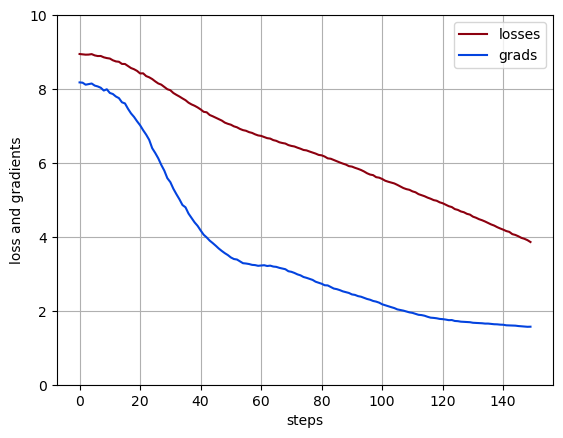

In [37]:
import numpy as np
x = np.arange(150)

fig, ax = plt.subplots()
ax.plot(x, df_test["losses"], 'xkcd:crimson', label='losses')
ax.plot(x, df_test["grads"], 'xkcd:blue', label='grads')
ax.set(xlabel='steps', ylabel='loss and gradients',)
ax.grid()
ax.set_ylim(ymin=0, ymax=10)
ax.legend()
plt.show()

# Check dataset

In [3]:
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast(tokenizer_file=r"".join(conf.tokenizer.tokenizer_path), bos_token="<bos>", eos_token="<eos>",
                pad_token="<pad>", unk_token="<unk>")

In [10]:
from util.prepara_data import prepare_data

train_loader, val_loader = prepare_data(tokenizer, conf)

Dataset loaded!
1813
127


In [17]:
min_en = 128
max_en = 0
min_de = 128
max_de = 0
for batch in train_loader:
    if batch['en']['input_ids'].shape[1] > max_en:
        max_en = batch['en']['input_ids'].shape[1]
    if  batch['en']['input_ids'].shape[1] < min_en:
        min_en = batch['en']['input_ids'].shape[1]
    if batch['de']['input_ids'].shape[1] > max_de:
        max_de = batch['de']['input_ids'].shape[1]
    if  batch['de']['input_ids'].shape[1] < min_de:
        min_de = batch['de']['input_ids'].shape[1]
    # print(f"Shape of the input ids: {batch['en']['input_ids'].shape}")
    # print(f"Shape of the target ids: {batch['de']['input_ids'].shape}")
print(max_en, min_en)
print(max_de, min_de)

41 13
45 14


In [26]:
for batch in train_loader:
    for i in range(batch["en"]["input_ids"].shape[0]):
        print({tokenizer.decode(batch["en"]["input_ids"][i])})
        print({tokenizer.decode(batch["de"]["input_ids"][i])})
    break

{'Two young, White males are outside near many bushes. <pad> <pad> <pad> <pad> <pad> <pad>'}
{'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche. <pad> <pad> <pad> <pad> <pad>'}
{'Several men in hard hats are operating a giant pulley system. <pad> <pad> <pad> <pad> <pad>'}
{'Mehrere Männer mit Schutzhelmen bedienen ein Antrie bsradsystem. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'}
{'A little girl climbing into a wooden playhouse. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'}
{'Ein kleines Mädchen klettert in ein Spielhaus aus Holz. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'}
{'A man in a blue shirt is standing on a ladder cleaning a window. <pad> <pad>'}
{'Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster. <pad> <pad> <pad>'}
{'Two men are at the stove preparing food. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'}
{'Zwei Männer stehen am Herd und bereiten Essen zu. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'}
{'A ma

# Hyperparameter search

In [49]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

df = pd.read_csv(r"LOGS-PATH")
df

,losses,gradient_norm,learning_rate,warmup
0,8.787248,8.163379,0.000016,200
1,8.517779,7.381928,0.000031,200
2,8.126037,5.726386,0.000047,200
3,7.730724,4.256516,0.000063,200
4,7.390090,3.392940,0.000078,200
...,...,...,...,...
130,7.309326,3.433675,0.000033,600
131,7.165235,3.151662,0.000036,600
132,7.027723,2.938670,0.000039,600
133,6.914384,2.805097,0.000042,600


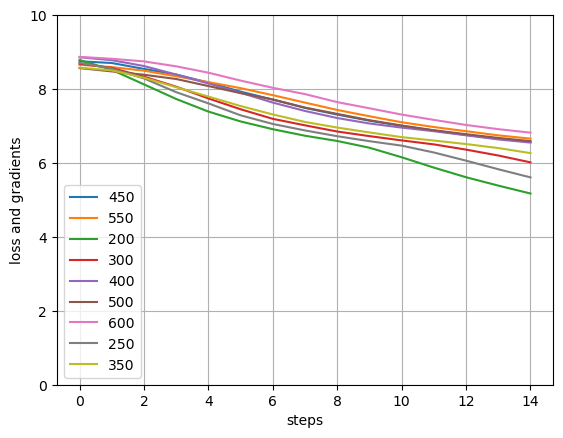

In [63]:
import numpy as np
x = np.arange(len(df[df["warmup"]==200]["losses"]))

fig, ax = plt.subplots()
for i in set(df["warmup"]):
    ax.plot(x, df[df["warmup"]==i]["losses"], label=i)

# ax.plot(x, df["gradient_norm"], 'xkcd:blue', label='grads')
ax.set(xlabel='steps', ylabel='loss and gradients',)
ax.grid()
ax.set_ylim(ymin=0, ymax=10)
ax.legend()
plt.show()

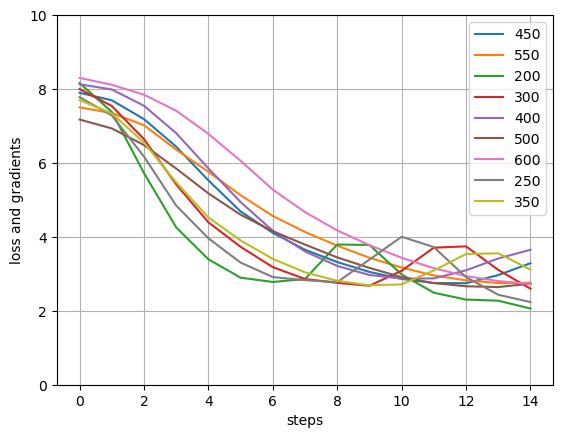

In [55]:
import numpy as np
x = np.arange(len(df[df["warmup"]==200]["gradient_norm"]))

fig, ax = plt.subplots()
for i in set(df["warmup"]):
    ax.plot(x, df[df["warmup"]==i]["gradient_norm"], label=i)
# ax.plot(x, df["gradient_norm"], 'xkcd:blue', label='grads')
ax.set(xlabel='steps', ylabel='loss and gradients',)
ax.grid()
ax.set_ylim(ymin=0, ymax=10)
ax.legend()
plt.show()

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

df = pd.read_csv(r"HP-SEARCH-FILE")
df

,losses,gradient_norm,learning_rate,warmup
0,7.365811,11.663502,0.000016,200
1,7.054453,10.086513,0.000031,200
2,6.602150,6.441980,0.000047,200
3,6.252896,3.314013,0.000063,200
4,6.003633,2.196184,0.000078,200
...,...,...,...,...
1111,1.391969,0.086265,0.000696,500
1112,1.391603,0.075964,0.000700,500
1113,1.391375,0.055058,0.000704,500
1114,1.390859,0.042752,0.000708,500


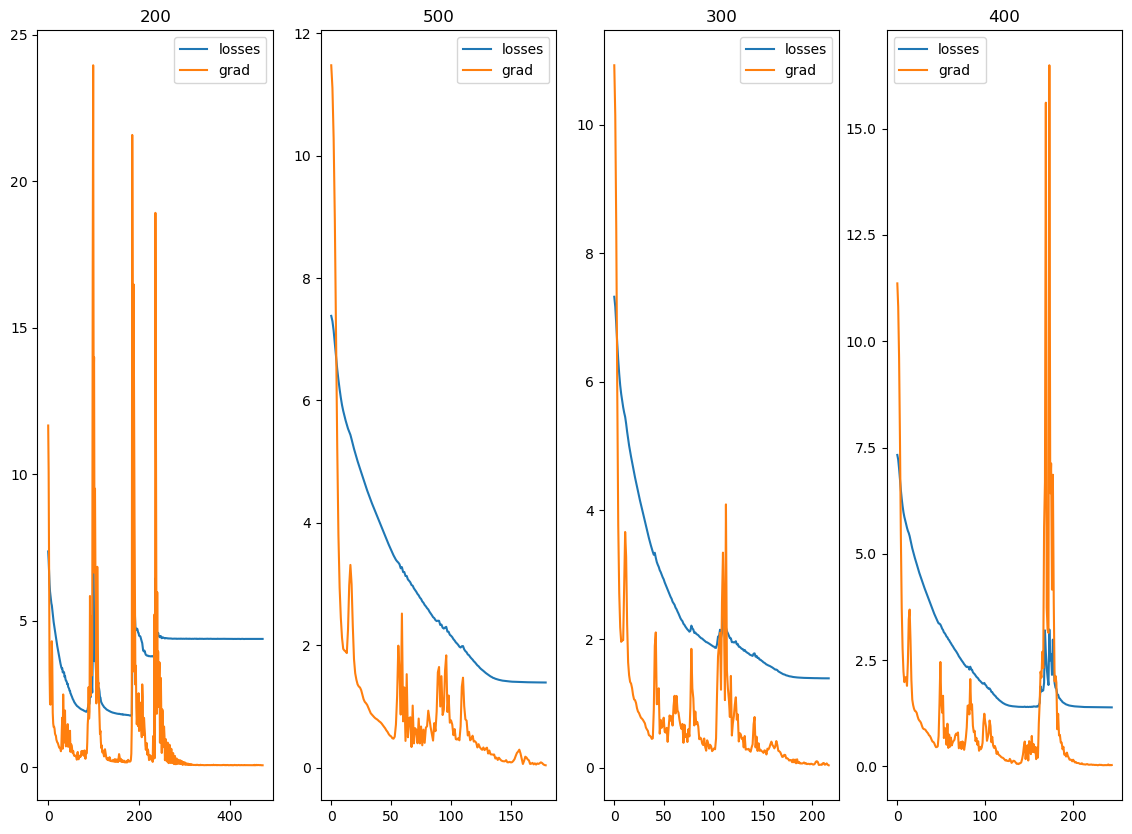

In [4]:
import numpy as np

fig, ax = plt.subplots(1, 4, figsize=(14, 10))
for i, warmup in enumerate(set(df["warmup"])):
    x = np.arange(len(df[df["warmup"]==warmup]["losses"]))
    ax[i].plot(x, df[df["warmup"]==warmup]["losses"], label="losses")
    ax[i].plot(x, df[df["warmup"]==warmup]["gradient_norm"], label="grad")
    ax[i].set_title(f"{warmup}")
    ax[i].legend()

plt.legend()
plt.show()

In [5]:
for i, warmup in enumerate(set(df["warmup"])):
    min = df[df["warmup"]==warmup]["losses"].min()
    max_grad = df[df["warmup"]==warmup]["gradient_norm"].max()

    print(f"Warmup step: {warmup} with min loss: {min} and max grad: {max_grad}")

Warmup step: 200 with min loss: 1.759056568145752 and max grad: 23.95789909362793
Warmup step: 500 with min loss: 1.3908591270446775 and max grad: 11.475682258605955
Warmup step: 300 with min loss: 1.3893659114837646 and max grad: 10.924259185791016
Warmup step: 400 with min loss: 1.387832522392273 and max grad: 16.490156173706055


We can see that 500 and 300 warmup steps seem to be the best values, when using 200 we can see that there is a gradient explosion and after that the model stops to improve. The second run we did had this problem, we used 80 warmup steps with the 192 batch size, but the model got stucked at 4.5 loss, same as in the graph before. Once there is a gradient explosion, despite clipping the gradient norm to a maximum value of 5.0, the model breaks. 500 warmup steps gets into a plateau really fast, however in the real training this won't happen as batch are diverse.

Also an interesting point is the minimum loss, in this case we are just overfitting in a batch looking for the minimum loss this model can get. Therefore, we can expect that during training loss won't go down more than around 1.4. During the first run we achieved a training loss of around 1.9 but validation loss got stucked in around 2.4.

# Grad Norm

In [18]:
import torch
v = torch.rand(12) * 2
v_1 = v.clone()
v.requires_grad_(True)
v_1.requires_grad_(True)

loss = 1/2 * torch.sum(v_1 * v_1 + v * v)
# Here grads of loss w.r.t v and v_1 should be v and v_1 respectively
loss.backward()

# Clip grads of v_1
max_norm = 1.0
torch.nn.utils.clip_grad_norm_(v_1, max_norm=max_norm, norm_type=2)

print(f"Original gradient: {v.grad}")
print(f"Clipped gradient: {v_1.grad}")
print(f"Gradient clipping formula without taking into account the norm: {(v.grad / torch.norm(v.grad, p=2)) * max_norm}")
print("*"*20)
print(f"Gradient Norm: {v.grad.norm()}")
clip_coef = max_norm / (v.grad.norm() + 1e-6)
print(f"Clip coefficient: {clip_coef}")
clip_coef = torch.clamp(clip_coef, max=1.0)
print(f"Now we need that the Clip coefficient is smaller or equal than 0 so we get: {clip_coef}")
print(f"Finnaly we multiply the clip_coef to the normalized grads: {v.grad * clip_coef}")
print(f" Norm of the new vector: {v_1.grad.norm()}")

Original gradient: tensor([1.9167, 0.3292, 1.1135, 0.8755, 1.0698, 0.6232, 1.0539, 0.2311, 0.5017,
        1.0074, 0.2277, 0.3423])
Clipped gradient: tensor([0.6085, 0.1045, 0.3535, 0.2780, 0.3396, 0.1979, 0.3346, 0.0734, 0.1593,
        0.3198, 0.0723, 0.1087])
Gradient clipping formula without taking into account the norm: tensor([0.6085, 0.1045, 0.3535, 0.2780, 0.3396, 0.1979, 0.3346, 0.0734, 0.1593,
        0.3198, 0.0723, 0.1087])
********************
Gradient Norm: 3.1497974395751953
Clip coefficient: 0.3174806237220764
Now we need that the Clip coefficient is smaller or equal than 0 so we get: 0.3174806237220764
Finnaly we multiply the clip_coef to the normalized grads: tensor([0.6085, 0.1045, 0.3535, 0.2780, 0.3396, 0.1979, 0.3346, 0.0734, 0.1593,
        0.3198, 0.0723, 0.1087])
 Norm of the new vector: 0.9999997019767761


In [17]:
v = torch.rand(12) * 2
v_1 = v.clone()
v.requires_grad_(True)
v_1.requires_grad_(True)

loss = 1/2 * torch.sum(v_1 * v_1 + v * v)
# Here grads of loss w.r.t v and v_1 should be v and v_1 respectively
loss.backward()

# Clip grads of v_1
max_norm = 5.0
torch.nn.utils.clip_grad_norm_(v_1, max_norm=max_norm, norm_type=2)

print(f"Original gradient: {v.grad}")
print(f"Clipped gradient: {v_1.grad}")
print(f"Gradient clipping formula without taking into account the norm: {(v.grad / torch.norm(v.grad, p=2)) * max_norm}")
print("*"*20)
print(f"Gradient Norm: {v.grad.norm()}")
clip_coef = max_norm / (v.grad.norm() + 1e-6)
print(f"Clip coefficient: {clip_coef}")
clip_coef = torch.clamp(clip_coef, max=1.0)
print(f"Now we need that the Clip coefficient is smaller or equal than 0 so we get: {clip_coef}")
print(f"Finnaly we multiply the clip_coef to the normalized grads: {v.grad * clip_coef}")
print(f" Norm of the new vector: {v_1.grad.norm()}")

Original gradient: tensor([0.0851, 0.4541, 0.8141, 0.3610, 0.4715, 1.4542, 1.6544, 0.1027, 1.9995,
        0.2160, 0.4602, 1.2175])
Clipped gradient: tensor([0.0851, 0.4541, 0.8141, 0.3610, 0.4715, 1.4542, 1.6544, 0.1027, 1.9995,
        0.2160, 0.4602, 1.2175])
Gradient clipping formula without taking into account the norm: tensor([0.1237, 0.6602, 1.1835, 0.5248, 0.6854, 2.1140, 2.4050, 0.1494, 2.9067,
        0.3140, 0.6690, 1.7699])
********************
Gradient Norm: 3.439481496810913
Clip coefficient: 1.4537070989608765
Now we need that the Clip coefficient is smaller or equal than 0 so we get: 1.0
Finnaly we multiply the clip_coef to the normalized grads: tensor([0.0851, 0.4541, 0.8141, 0.3610, 0.4715, 1.4542, 1.6544, 0.1027, 1.9995,
        0.2160, 0.4602, 1.2175])
 Norm of the new vector: 3.439481496810913


We can see that torch doesn't normalize and then multiply by a factor the gradients, it just multiplies by a factor. Torch computes the total norm and divides the max norm by it, getting the scale factor. For example, if max_norm/total_norm = 2 then by multiplying all the gradients by 2 we will get the max norm. However, we don't want to make gradients bigger, at most we want them to be below a threshold, so by using the torch.clamp we ensure that gradients don't get augmented. So that if we have a norm smaller than the threshold, we don't change anything.